# CMSE 831 Final Project
### Mae Frost
#### 5 December 2025

# ___Pursuit of Translating Targets as a Generalized Travelling Salesman Problem___

## Background and Motivation


In our past work [1], we considered a scenario in which a pursuing autonomous vehicle must intercept a series of targets that are moving at a fixed speed before returning to its depot. The targets are said to be translating across the plane, as they all move in the same direction (which we can assume without loss of generality to be parallel to the positive x-axis). We assumed that the pursuing vehicle was capable of firing a projectile with limited range at each of the targets, meaning that the pursuer does not need to directly intercept each target, only get within a limited range.

The primary results of this work were as follows. Under some assumptions on the dynamics of the pursuer, projectile, and targets:
1. The set of valid points around each target that the pursuer can fire the projectile from is given by a circle;
1. Even though the targets are moving, the problem can be analyzed in a static frame by applying a specially designed coordinate transformation;
1. After the transformation is applied, the (moving) circle of valid interception points around each target becomes a (static) ellipse.

These results imply that an optimal motion path for the pursuer can be determined by finding the shortest route that begins at the origin, passes through each of the elliptical regions around the targets, and then returns to the origin. **The primary goal of this project will be to investigate and compare methods for determining this optimal route.**

The problem of determining the route above is similar to the famous Travelling Salesman problem (TSP) which is defined as follows.

**Travelling Salesman Problem:** Given a set of cities, determine the minimum cost route that visits every city exactly once and then returns to the starting city.

The TSP is one of the most famous problems in combinatorial optimization, and is known to be NP-Hard [2], i.e., there is no known polynomial-time algorithm for determining a TSP route. Our problem differs from the TSP in two key ways: (1) We only need to visit an elliptical "neighborhood" around each target; and (2) the neighborhoods define a continuous space rather than a set of discrete locations. The first of these differences (the problem of neighborhoods) can be addressed by considering a generalization of the TSP known aptly as the **Generalized Travelling Salesman Problem (GTSP)** [3]. In an instance of GTSP, the cities have been partitioned into disjoint nodesets known as neighborhoods, and the goal is to determine the shortest route that visits each neighborhood exactly once. A key result in the study of the GTSP is the Noon-Bean transformation [4], which can transform any instance of GTSP into an equivalent instance of the Asymmetric Travelling Salesman Proplem (ATSP) (i.e., a TSP where the distance from city A to city B may not equal the distance from B to A ). The second difference in our problem (continuous neighborhoods), can be addressed by considering a special structure, introduced in [5], known as a graph of convex sets (GCS). In this setting, the city positions are not fixed, and are rather said to be contained with in a series of convex sets. Solving the TSP over a graph of convex sets involves determining not only the minimum route, but also the position of each city within the set (which will determine the length of the final route). 

In this project, we will study three methods for solving the underlying GTSP problem inherent to the problem above.
1. First, we will obtain an upper bound on the length of the pursuer's path by considering a TSP instance where the city locations are given by the center of the ellipse. We then solve the TSP using a mixed integer linear programming (MILP) formulation of TSP. 
1. We will then model the problem as a GTSP instance, discretizing the city locations by sampling within each of the elliptical neighborhoods. We then apply the Noon-Bean transformation to obtain an instance of ATSP. We then compare two solution methods for the generated ATSP: an MILP formulation and a simulated annealing-based solution method. 
1. Finally, we will model the problem as a graph of convex sets which admits a solution as a mixed integer convex program (MICP).

The research questions this project seek to answer are:
1. Which of the above methods produces the best tour for a given problem instance?
2. Which of the above methods is most scalable to large problem instances?



#### Python Package Requirements
The following code imports the necessary packages to run this file 
The only "unusual" package here is `gcsopt` [6] which will do the heavy lifting for the graphs of convex sets approach (as manual implementation of this technique is far beyond the scope of this course and my ability to work with convex optimization problems). Installation is relatively straight forward and can be found __[here](https://github.com/TobiaMarcucci/gcsopt)__. The code here assumes that the MICP solver MOSEK is installed as it is needed to solve the GCS formulation. Academic Licenses are free of charge and the previous link contains instructions for obtaining one.

In [129]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import copy
import cvxpy as cp
import itertools
import random
from collections.abc import Callable
from gcsopt import GraphOfConvexSets
from tqdm import tqdm
import time

## Methodology

#### Part 0: Problem Setup
In this section we will design the necessary functions to visualize create a problem instance of our heterogeneous pursuit problem. The important problem parameters for our purposes are:
1. $n$: the total number of targets.
1. $S$: a set of starting location for the $n$ targets.
1. $1 > \alpha > 0$: the maximum velocity of the projectile 
1. $T$: The time it takes the projectile to intercept a target after firing 
1. $\mu < \alpha$: the speed at which the targets move.
1. Speed of pursuer is unity

All of these will be considered to be hyperparameters of a problem instance and known *a priori*.

To begin, we must first design a functionality to find and visualize the circular regions around each target, the capture regions, at time zero. Drawing on our previous work [1], we know that, given a starting location $(x,y)$, the capture circle around the target at time zero has center $(x+\mu T,\, y)$ and radius $\alpha T$.

The following function accepts the problem parameters as input and returns the radius and center points of the circles.

In [3]:
# deterimines the center and radius of the capture circles for the intercept problem
# Parameters: 
#   starting points: a numpy arry of size nx2 representing the starting locations of the n targets
#   alpha: The velocity of the interceptor 
#   T: Time required by interceptor to hit target
#   mu: The velocity of of the target, mu < alpha
# Returns:
#   circle centers: A numpy array of size nx2 representing the centers of the capture circles at time 0
#   radius: the radius of the capture circles (uniform for all targets)
def get_init_capture_circles(starting_points: np.ndarray, alpha: float, T: float, mu: float) -> tuple[np.ndarray, float]:
    radius = alpha * T
    circle_centers = np.zeros(starting_points.shape)
    circle_centers[:, 0] = starting_points[:,0] + (mu * T)
    circle_centers[:, 1] = starting_points[:,1]
    return circle_centers, radius

Throughout the methodology section, we will work with a small example to demonstrate the functionality of our code. Below we see the circle centers and radius associated with this example.

In [4]:
start = np.array([
        [5,1],
        [3,3],
        [1.5,1],
        [1,3.8]
    ])
alpha = 0.9
T = 0.5
mu = 0.5 
centers, radius = get_init_capture_circles(start, alpha, T, mu)

print(f'{centers=}')
print(f'{radius=}')

centers=array([[5.25, 1.  ],
       [3.25, 3.  ],
       [1.75, 1.  ],
       [1.25, 3.8 ]])
radius=0.45


We now develop a function that will visualize these inital condtions for a given problem instance.

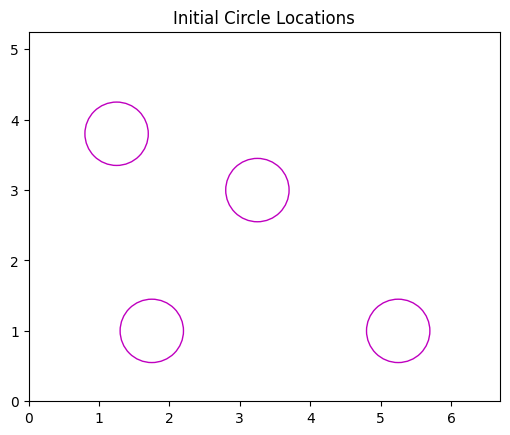

In [5]:
# visualizes the inital condtions for a given problem instance 
# Parameters: 
#   circle_centers : a numpy arry of size nx2 representing the centers of each capture circle at time 0
#   radius : the radius of the capture circles
#   show : a boolean utility parameter that allows the plot to be manually shown at a later time
#   data : a list of Anyx2 numpy arrays, a utility parameter that allows for points to be plotted within each circle
def visualize_circles(circle_centers : np.ndarray, radius : float, show=True, data=None) -> None:
    fig , ax = plt.subplots()
    for i in range(circle_centers.shape[0]): # plot each of the circles
        c = patches.Circle(circle_centers[i,:], radius, color='m', fill=False)
        ax.add_patch(c)
        
    ax.set_aspect('equal', adjustable='box')
    x_max, y_max = np.max(circle_centers[:,0])+radius+1, np.max(circle_centers[:,1])+radius+1 # determine the x and y limits so that all circles can been seen
    ax.set_xlim(0, x_max)
    ax.set_ylim(0, y_max)    
    ax.set_xticks(range(int(x_max)+1))
    ax.set_yticks(range(int(y_max)+1))
    if data is not None: # plot any data that was passed to the function
        for data_set in data:
            plt.scatter(data_set[:,0], data_set[:,1], c='b')
    if show:
        plt.title('Initial Circle Locations')
        plt.show()

# create a plot of our example problem
visualize_circles(centers, radius)


The plot above shows the capture circles for our example problem at time zero. As time progresses, these circles will translate across the plane at speed $\mu$. To make the route eaiser to calculate, we will apply a coordinate transformation that will allow us to solve the problem in a static frame. Let $(x,y)$ be the initial location of a point in $\mathcal{R}^{2}$ in the dynamic frame. It's location in the static frame is given by:
$$ \left ( \frac{x}{1-\mu^{2}},\, \frac{y}{\sqrt{1-\mu^{2}}} \right ) $$

One of the results of our previous work [1] was that applying the above transformation to the circles seen above produces a set of ellipses. For a target with the starting location $(x,y)$, the ellipse in the static frame has center
$$ \left ( \frac{x+ \mu T}{1-\mu^{2}},\, \frac{y}{\sqrt{1-\mu^{2}}} \right ), $$
semi-major axis
$$ a = \frac{\alpha T}{1-\mu^{2}}, $$
and semi-minor axis 
$$ b = \frac{\alpha T}{\sqrt{1-\mu^{2}}}. $$

The following functions visualizes these ellipses given the problem paramters and transfroms an arbitrary set of points in the dynamic frame to the static frame.

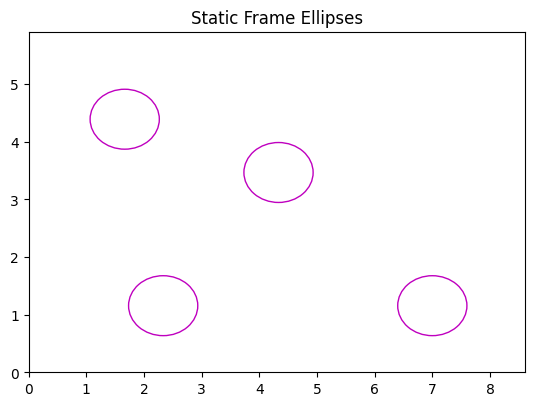

In [6]:
# visualizes the inital condtions for a given problem instance 
# Parameters: 
#   starting points: a numpy arry of size nx2 representing the starting locations of the n targets
#   alpha: The velocity of the interceptor 
#   T: Time required by interceptor to hit target
#   mu: The velocity of of the target, mu < alpha
#   show : a boolean utility parameter that allows the plot to be manually shown at a later time
#   data : a list of Anyx2 numpy arrays, a utility parameter that allows for points to be plotted within each circle
def visualize_ellipses(starting_points: np.ndarray, alpha: float, T: float, mu: float, show=True, data=None) -> None:

    # detrimine the ellipse parameters using the equations above
    major_axis = (alpha*T) / (1- (mu**2))
    minor_axis = (alpha*T) / np.sqrt((1- (mu**2)))
    ellipse_centers = np.zeros(starting_points.shape)
    ellipse_centers[:,0] = (starting_points[:,0] + (mu*T)) / (1- (mu**2))
    ellipse_centers[:,1] = starting_points[:,1] / np.sqrt((1- (mu**2)))

    # plot the found ellipses 
    fig , ax = plt.subplots()
    for i in range(ellipse_centers.shape[0]):
        el = patches.Ellipse(ellipse_centers[i,:], width=2*major_axis, height=2*minor_axis, color='m', fill=False)
        ax.add_patch(el)
    ax.set_aspect('equal', adjustable='box')   
    # determine the x and y limits so that all ellipses can been seen
    x_max, y_max = np.max(ellipse_centers[:,0])+major_axis+1, np.max(ellipse_centers[:,1])+minor_axis+1
    ax.set_xlim(0, x_max)
    ax.set_ylim(0, y_max)    
    ax.set_xticks(range(int(x_max)+1))
    ax.set_yticks(range(int(y_max)+1))
    if data is not None:
        for data_set in data:
            plt.scatter(data_set[:,0], data_set[:,1], c='b')
    if show:
        plt.title('Static Frame Ellipses')
        plt.show()

# call the function on our example problem 
visualize_ellipses(start, alpha, T, mu)

# transforms an arbitrary set of points in the static frame to the dynamic frame 
# Parameters: 
#    Samples: a list of numpy arrays of size any x 2 containing inital points in the dynamic frame
#    Mu: the target velocity 
# Returns
#   static samples: a list of numpy arrays of the same size containing the corresponding points in the static frame
def static_frame_transform(samples: list[np.ndarray], mu: float) -> list[np.ndarray]:
    static_samples = []
    for sample in samples:
        t = np.zeros(sample.shape)
        t[:,0] = sample[:,0] / (1-(mu)**2)
        t[:,1] = sample[:,1] / np.sqrt(1-(mu)**2)
        static_samples.append(t)
    return static_samples


Notice that, after applying the transform, the circles have become ellipses and the total region considered has expanded along the x-axis. The importance of these ellipses is that any (G)TSP route found in this frame of reference can be transformed back to the dynamic frame as part of a valid TSP tour. That is, say that the optimal tour in the static setting first visits some point $a$ in the lower lefthand ellipse. It can be shown that an optimal tour in the dynamic frame (where the targets move) visits the corresponding location within the lower lefthand circle first. 

Thus, the goal of the remainder of this project will be to solve (G)TSP though these elliptical neighborhoods. 

#### Part 1: An Upper Bound From a TSP Formulation

Our first approach to is to essentially ignore the neighborhood aspect of the problem and solve as a traditional TSP. In this approach, we will use the center of each ellipse as a city location and apply a MILP formulation of the TSP to find a route. The benefits of such an approach are twofold.

**Scalability:** By removing the neighborhoods from consideration, we greatly simplify the problem. Rather than needing to select from a continuous set of points in each neighborhood, we now only need consider a discrete number of points equal to the total number of targets. Furthermore, while the TSP is NP-Hard, making it difficult to solve, modern MILP solvers can typically handle problems with between 30-40 cities on commercial hardware without too much difficulty.

**An Upper Bound on Tour Length:** As this approach ignores the neighborhoods aspect of the problem, there is little doubt that the tours it produces are suboptimal. However, the results from this section should provide a good baseline to compare our more sophisticated approaches to.

The first step of this approach will be to find the city locations in static frame. The following code derives these locations for our example problem.

In [7]:
static_locations = static_frame_transform([centers], mu) # transform the circle centers we found before to the elliptical setting
static_locations = static_locations[0]

print('City Locations:')
for i in range(static_locations.shape[0]):
    print(f'  City {i+1}: {static_locations[i]}')

City Locations:
  City 1: [7.         1.15470054]
  City 2: [4.33333333 3.46410162]
  City 3: [2.33333333 1.15470054]
  City 4: [1.66666667 4.38786205]


Recall, that the pursuer is assumed to start from the origin. For this reason we add an extra city at $(0,0)$ to represent the pursuer's starting point. Note that the origin is invarient under the coordinate transformation so we do not need to apply the transform. The following shows the final TSP instance that we will try to solve.

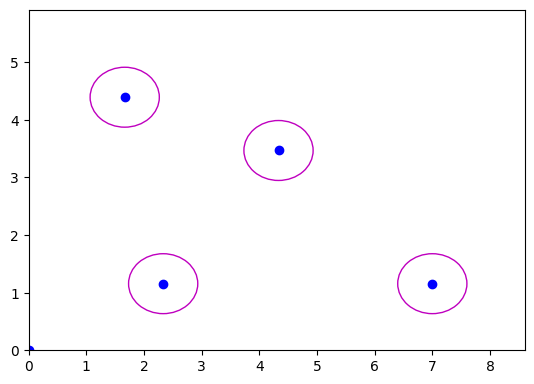

In [8]:
# add the origin as a city
starting_point = np.zeros((1,2))

static_locations = np.vstack((starting_point, static_locations))

# visualize the ellipses again, showing the city locations
visualize_ellipses(start, alpha, T, mu, show=False)
plt.scatter(static_locations[:,0], static_locations[:,1], c='b')
plt.show()

The figure above shows our final TSP instance. We will solve the problem as a mixed integer linear program. While several notable MILP formulations of the travelling salesman problem exist, the key idea is to introduce a series of binary decision variables $x_{ij}$ corresponding to each pair of cities [7]. The idea is then that the variable should take a value of 1 if the optimal path goes from city $i$ to city $j$ and 0 if the optimal path does not. Formally,
$$
    x_{ij} = \left \{ 
        \begin{array}{ll}
        1 & \text{TSP path goes directly from city } i \text{ to city } j \\
        0 & \text{otherwise} \\
        \end{array}
    \right .
$$
We then introduce a series of coefficients $c_{ij}$ which are equal to the distance between city $i$ and city $j$. Together, these allow us to write the following (linear) objective function for the TSP, 
$$ \min \sum_{i=1}^{n}\, \sum_{j=1,\, j\neq i}^{n}\, c_{ij}x_{i,j} $$
**Subject to** 
$$ x_{i,j} \in \{0,1\} \quad i,j = 1, \dots, n$$

The key issue with the problem as stated above, is that it has a clear minimum when all values of $x$ are equal to zero. This  minimum  does not correspond to a valid TSP tour, so many formulations also add the following constraints that ensure every vertex is visited by the tour.
$$ \sum_{i=1\, i\neq j} x_{ij} = 1 \quad j=1, \dots, n $$
and
$$ \sum_{j=1\, j\neq i} x_{ij} = 1 \quad i=1, \dots, n $$
The first of these constraints states that every city has exactly one incoming leg of the tour and the second states that every city has exactly one outgoing leg of the tour. That is, together they require that each city is visited exactly once along the tour. Implementation wise, if we think of the decision variables $x_{ij}$ as forming a matrix where an entry $ij$ represents if the tour contains the edge between city $i$ and city $j$, these constraints  require that each row and column of the matrix contains exactly one entry with value 1 and that all remaining entries have value 0. 

The following code implements these contraints for our sample problem using the `cvxpy` package [8], which allows for easy implementation of mathematical programs.

In [9]:
# finds the coeffiencts for our MILP formulation of TSP given the starting points.
# Parameters: 
#   city_locations: a numpy array of size n x 2 containing the city locations for the problem
# Returns:
#  an n x n matrix where the entries correspond to the euclidean distance between cities i and j
def find_c_matrix(city_locations: np.ndarray) -> np.ndarray:
    num_cities = city_locations.shape[0]
    c_matrix = np.zeros((num_cities, num_cities))
    for i in range(num_cities):
        for j in range(num_cities):
            if i != j: # the distance between a city and itself is zero
                c_matrix[i,j] = np.linalg.norm(city_locations[i] - city_locations[j])
    return c_matrix

C = find_c_matrix(static_locations)
# print(static_locations)
print('C matrix')
print(C)
# define the X matrix for our problem
X = cp.Variable(C.shape, boolean=True)  # one binary decision variable for each possible leg of the path

# now define the objective function 
objective_function = cp.Minimize(cp.sum(cp.multiply(C, X))) # minimize( element wise multiply the matricies C and X then sum all values of the result)

# Now define a list of constraints
constraints = []
ones_vector = np.ones((C.shape[0], 1)) # a ones vector we will use to ensure the rows and cols sum to 1
constraints.append(X @ ones_vector == ones_vector) # the sum of each row of X equals 1
constraints.append(X.T @ ones_vector == ones_vector) # the sum of each col of X equals 1
constraints.append(cp.diag(X) == 0) # this ensures that the i !=j and j != i parts of the constraints are enforced, ie you cannopt travel from a city to itself



C matrix
[[0.         7.09459888 5.54777233 2.60341656 4.69373104]
 [7.09459888 0.         3.52766841 4.66666667 6.2368083 ]
 [5.54777233 3.52766841 0.         3.05505046 2.82213473]
 [2.60341656 4.66666667 3.05505046 0.         3.30117824]
 [4.69373104 6.2368083  2.82213473 3.30117824 0.        ]]


The program as stated above can actually be solved quite efficently. However, there is a key issue that might not be immeadiatly apparent until we try to solve the program. Let us solve the above and see where the issue lies.

X matrix
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
  5.55111512e-17]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [5.55111512e-17 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.00000000e+00]
 [1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]]


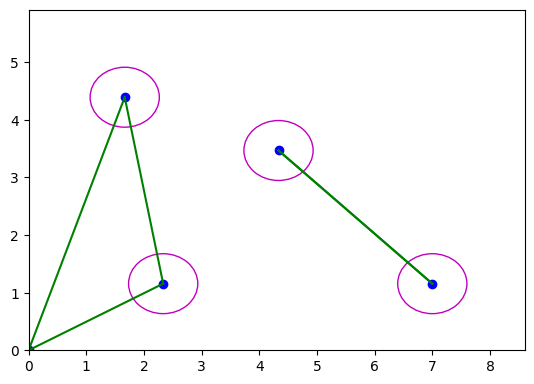

In [10]:
program = cp.Problem(objective_function, constraints) # define the program with cvxpy
program.solve('MOSEK', verbose=False) # solve using the MOSEK solver

#show the x matrix we found 
print('X matrix')
print(X.value)

# extract the values of the matrix where x_ij = 1 so we can show the tour 
path_ind = np.argwhere(X.value >= 0.5)

# plot the problem again
visualize_ellipses(start, alpha, T, mu, show=False)
plt.scatter(static_locations[:,0], static_locations[:,1], c='b')

# draw a line between the edges indicated by our solution
for city_pair in path_ind:
    city1 , city2 = city_pair[0], city_pair[1]
    edge_points = np.array([static_locations[city1, :], static_locations[city2, :]])
    plt.plot(edge_points[:,0], edge_points[:,1], c='g')
plt.show()

As we can see, the program above did not actually produce a valid  Travelling Salesman Path. This is because, while the specified constraints so far enforce that each city is visited, they do not enforce that every city must fall on the same tour. The distinct components seen above are commonly referred to as subtours, and it is removing them that makes solving TSP so difficult. 

While there are several ways to specify constraints that remove these subtours, I will  adopt  the Miller-Tucker-Zemlin (MTZ) formulation of __subtour elimination constraints__ for their simplicity of implementation [7]. The key idea behind the MTZ constraints is to introduce a new set of $n$ variables that will correspond to each vertex. These variables $t_{1}, \dots, t_{n}$ represent the time that the cities are visited at. The idea is that we can set the value of $t_{1} = 1$ and then enforce that $t_{j} \geq t_{i} + 1$ if $x_{ij} = 1$ whenever $i$ and $j$ are not equal to 1. This means that the value of $t$ has to increase along the path and is only allowed to decrease when the path returns to its starting point. Since any subtour (except the one containing the starting point) will not meet this condition, adding constraints of this form prevent our solution from containing subtours. The common implementation of the MTZ constraints are as follows [9]:
$$ t_{1} = 1 $$
$$ t_{i} - t_{j} + 1 \leq (n-1)(1-x_{ij})  \quad i,j \in \{2, \dots, n\},\, i\neq j $$
$$ 2 \leq t_{i} \leq n \quad i \in \{2, \dots, n\}$$

The second of these constraints encodes the implication that $t_{j} \geq t_{i} + 1$ if $x_{ij} = 1$ (and that we dont care about the relationship between $t_{i}$ and $t_{j}$ if $x_{ij} = 0$) [9]. 

We will add these constraints to our program and see if it fixes our solution.

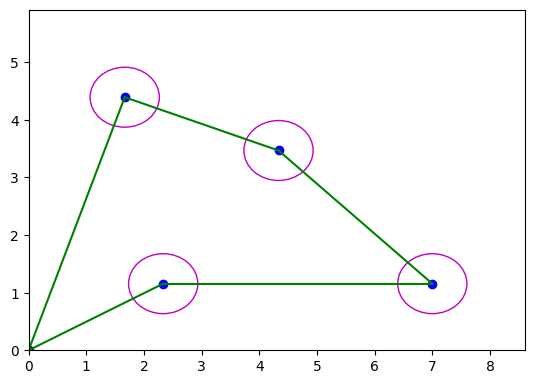

In [11]:
# reset the value of x, the objective function and redefine the constraints from above
X = cp.Variable(C.shape, boolean=True)

objective_function = cp.Minimize(cp.sum(cp.multiply(C, X)))
constraints = []
constraints.append(X @ ones_vector == ones_vector) 
constraints.append(X.T @ ones_vector == ones_vector) 
constraints.append(cp.diag(X) == 0) 

n = C.shape[0]

#  now add the new t varaibles and constraints 
t = cp.Variable(n)
constraints.append(t[0] == 1) # time for the first city is 1
constraints.append(t[1:] <= n) # t2 ... tn <= n
constraints.append(t[1:] >= 2) # t2 ... tn >= 2

# now add the increasing time constraints for all distinct pairs of i and j
for i in range(1, n):
    for j in range(1, n):
        if i != j:
            constraints.append(t[i]- t[j] + 1 <= (n-1)*(1-X[i,j]))

# now resolve our problem 
program = cp.Problem(objective_function, constraints) # define the program with cvxpy
program.solve('MOSEK', verbose=False) # solve using the MOSEK solver

# extract the values of the matrix where x_ij = 1 so we can show the tour 
path_ind = np.argwhere(X.value >= 0.5)

# plot the problem again
visualize_ellipses(start, alpha, T, mu, show=False)
plt.scatter(static_locations[:,0], static_locations[:,1], c='b')

# draw a line between the edges indicated by our solution
for city_pair in path_ind:
    city1 , city2 = city_pair[0], city_pair[1]
    edge_points = np.array([static_locations[city1, :], static_locations[city2, :]])
    plt.plot(edge_points[:,0], edge_points[:,1], c='g')
plt.show()


As seen above, we now have a valid TSP tour, and hopefully a valid upper bound for our problem solution. We can compute the total distance of our tour as follows.

In [12]:
total_cost = np.sum(C * X.value)
print(f'Total cost of TSP solution: {total_cost}')

Total cost of TSP solution: 18.313617415612416


This givens us an upper bound on the length of the optimal tour for the pursuer of around 18.31.

#### Part 2: Sampling Based GTSP Formulations Through Simulated Annealing and MILP

In this section, we will hopefully improve upon our previous solution by taking into account the elliptical neighborhoods around each of the targets. The general idea of our approach will be to sample some number of points $m$ around each of the targets and then create an instance of GTSP using these samples. Recall that in an instance of GTSP, the cites are grouped into clusters and the goal is to find the shortest tour that visits one node from each cluster. Here we will have one cluster for each target, with $m$ nodes in each cluster  consisting of the points we sampled. 

To solve the GTSP, we will utilize the Noon-Bean transformation [4] to produce an instance of the Asymmetric Travelling Salesman Problem (ATSP). We will then use to methods to try to solve the ATSP. First, we will apply the same MTZ formulation as above to attempt to solve the problem optimally. However, this approach greatly limits the number of points we can sample. Thus, we will also attempt to employ a simulated annealing approach to solve the ATSP instance.

To begin, we first create functions that can perform the sampling process. The idea is to sample uniformly within the circles at their initial locations and then transform these points to the static frame.

In [13]:
# sample points within a set of circles 
# parameters:
#   centers: a numpy array of size n x 2 containing the centers of the circles
#   radius: a float representing the radius of the circles 
#   m: an integer representing the number of points to sample within each circle
#   seed: (optional) the random seed to use while generating the points
# returns: 
#   a list of numpy arrays of size m x 2 containing the sampledpoints around each circle
def circle_sample(centers: np.ndarray, radius : float, m : int, seed=None) -> list[np.ndarray]:

    if seed is not None:
        np.random.seed(seed)

    samples = []
    for circle in range(centers.shape[0]):
        circle_points = []
        for _ in range(m):
            # create a random point in polar coordinates 
            r = radius * np.sqrt(np.random.random()) # we scale by the square too to prevent oversampling in the center of the circle
                                                     # see https://stackoverflow.com/questions/5837572/generate-a-random-point-within-a-circle-uniformly
                                                     # for more details
            theta = 2 * np.pi * np.random.random()

            # now return to cartesian coords 
            center_x, center_y = centers[circle, 0], centers[circle, 1]
            x = center_x + (r*np.cos(theta))
            y = center_y + (r*np.sin(theta))
            circle_points.append([x,y])
        samples.append(np.array(circle_points))
    return samples



Applying this to our example and visualizing in both frames when $m=4$ gives us

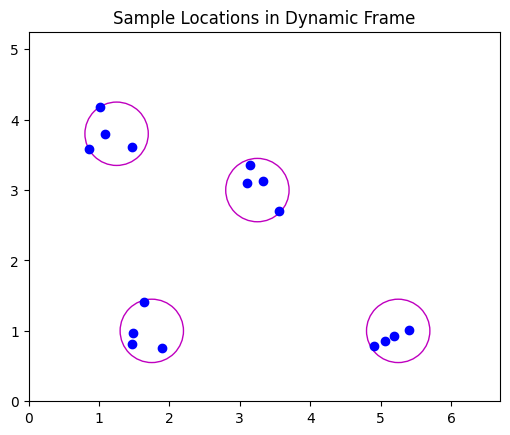

In [14]:
# apply the result to our sample problem and visualize 
samples = circle_sample(centers, radius, 4, seed=1127)
visualize_circles(centers, radius, show=False, data=samples)
plt.title('Sample Locations in Dynamic Frame')
plt.show()

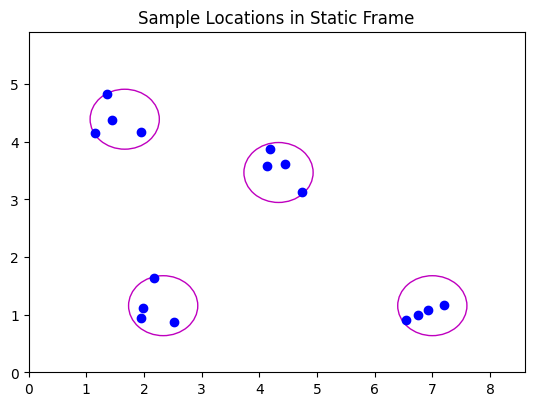

In [15]:
samples = static_frame_transform(samples, mu)
visualize_ellipses(start, alpha, T, mu, show=False, data=samples)
plt.title('Sample Locations in Static Frame')
plt.show()

For technical reasons related to the Noon-Bean transformation, it will be more convenient  to model the problem as a digraph. We will create the digraph as follows. For each sampled location, we add a node to the digraph. We then add one additional node to represent the starting location of the pursuer. We then add an arc from the pursuer to every node with weight equal to the Euclidean distance between their corresponding points. Finally, for each node in a cluster, we add an arc that connects it to every node that does not share a cluster with it, again weighting the arcs according to the Euclidean distance.

The following function generates this digraph representation using the `networkx` library. 

In [16]:
# Generates a networkx digraph representation of the GTSP problem
# Parameters
#   samples: a list of n numpy arrays of size n x 2 containing the sampled points
# Returns
#   The digraph representation
#   A list n+1 lists. The lists correspond to each cluster (with the origin node being its own cluster), inside each list are the integer labels of its nodes
def generate_digraph_representation(samples : list[np.ndarray]) -> tuple[nx.DiGraph, list[list[int]]]:
    # an empty graph object
    G = nx.DiGraph()


    # add nodes to the graph, storing their position as an attribute for later access
    G.add_node(0, position=np.array([0,0])) # node zero represents the origin
    label = 1 # labeling of other nodes begins at 1
    node_clusters = [[0]] # we will keep track of which nodes are in what circle to make adding the edges easier
    for sample in samples:
        cluster = []
        for i in range(sample.shape[0]):
            cluster.append(label)
            G.add_node(label, position=sample[i,:])
            label += 1
        node_clusters.append(cluster)
    
    # now we will add the edges to the graph, the graph is "almost" complete, all arcs are presnt save for those within the same cluster
    for i, cluster in enumerate(node_clusters):
        non_cluster_nodes = []
        for j in range(len(node_clusters)):
            if i != j:
                non_cluster_nodes += node_clusters[j]
        
        for c_node in cluster: 
            for node in non_cluster_nodes:
                # use the euclidean distance as the weight
                distance = np.linalg.norm(G.nodes[c_node]['position'] - G.nodes[node]['position'])
                G.add_edge(c_node, node, weight=distance)

    return G, node_clusters

We include a functionality to visualize the networkx graph representation.

In [17]:
# visualizes the digraph representation of the GTSP problem.
# Parameters
#   graph: the Digraph object to visualize
#   node_labels: boolean to display the node labels 
#   edge_weights: boolean to diplay the edge weights
def visualize_graph(graph : nx.DiGraph, node_labels=True, edge_weights=True) -> None:
    # create a positioning dictionary so the node postions are correct in space
    positioning = {}
    for node in graph.nodes:
        positioning[node] = tuple(graph.nodes[node]['position'])
    nx.draw(graph, pos=positioning)

    if node_labels:
        nx.draw_networkx_labels(graph, pos=positioning)
    if edge_weights:
        e_labs = {(u, v) : w for u, v, w in graph.edges(data="weight")}
        nx.draw_networkx_edge_labels(graph, pos=positioning, edge_labels=e_labs)

Note that becuase of how we struture the digraph, any solution to the TSP over the digraph corresponds exactly to the solution we are looking for, and we can quickly find the total length of a path by looking at the distance attributes we stored.

We now visualize the the digraph corresponding to our sample problem. To ease congestion in the image, we will not visualize the edge weights.

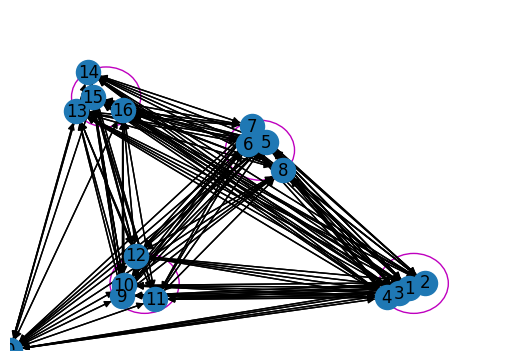

In [18]:
dg, n_clusters = generate_digraph_representation(samples) # create the digraph
visualize_ellipses(start, alpha, T, mu, show=False, data=samples) # show the ellipses 
visualize_graph(dg, edge_weights=False) # visualize the graph
plt.show()

We see that, due to the large number of edges, the digraph is quite congested, none the less it contains all of the data we need to solve the problem.

We now need to apply the Noon-Bean Transformation to change this GTSP instance to a problem we can solve with TSP techniques. The Noon-Bean transformation consists of 2 main parts as described in [4]
1. The problem is transformed into what is called a Clustered TSP problem. This is similar to a GTSP problem, but the salesman is required to visit all nodes in a given cluster before moving on to the next. This transformation is on a cluster by cluster basis. For each cluster, the nodes are assigned a label from 1 to $m$. Then for each arc leaving the cluster $(u,v)$ ($u$ is in the cluster and $v$ is not), it is replaced with an arc $(k,v)$ with the same weight, where $k$ is the node with label one less than %u% (wrapping around node 1 to node $m$). After this process is complete, a directed cycle within each cluster is created by adding zero cost arcs between nodes with labels $(1,2), (2,3), \dots, (m-1, m), (m,1)$ in each cluster. The result is a graph where all nodes within a cluster can be traveled through with total cost zero, meaning that the clustered TSP solution only depends on choosing the correct node to enter the cluster from.

1. After the clustered TSP instance is created, it can be transformed into an instance of ATSP by simply adding some large cost $\beta$ to every arc that spans between clusters. Specifically, $\beta$ should be larger than the total cost of all arcs in the Digraph. 

The result of this two part transformation is an instance of ATSP that we can solve in a similar manner to TSP. Using the solution from this ATSP instance, we can recover the best GTSP route in the original graph.

We begin implementing the transformation in step 1 to a clustered tsp.

In [19]:
# transforms a gtsp instance into a clustered TSP
# Parameters:
#   graph: the GTSP digraph
#   node_clusters: a list of lists containing the nodes in each cluster 
# Returns:
#   Nx Digraph corresponsing to the clustered tsp instance
def to_clustered_tsp(graph : nx.DiGraph, node_clusters : list[list[int]]) -> nx.DiGraph:
    c_tsp_graph = nx.DiGraph() # create a new digraph object to hold the CTSP instance 
    for node, pos in graph.nodes(data="position"): # add the nodes and their postioning data 
        c_tsp_graph.add_node(node, position=pos)
    
    # change arc (u,v) to arc (u-1, v)
    for cluster in node_clusters:
        # if the cluster has exactly one node, just copy its outgoing edges
        if len(cluster) == 1:
            arcs = list(graph.out_edges(cluster[0], data='weight'))
            
            for u , v , w in arcs:
                c_tsp_graph.add_edge(u,v, weight=w)
        # other wise adjust the arc so they eminate from the 'previous vertex' 
        else:
            max_node = max(cluster)
            for n_index, node in enumerate(cluster):
                if n_index == 0:
                    new_root = max_node
                else:
                    new_root = cluster[n_index-1]
                arcs = list(graph.out_edges(node, data='weight'))
                for u, v, w in arcs:
                    c_tsp_graph.add_edge(new_root, v, weight=w)
        
        # after this is done add a cycle of arcs in the cluster with weight 0
        
        if len(cluster) > 1:
            for i in range(len(cluster)):
                if i == len(cluster)-1:
                    c_tsp_graph.add_edge(cluster[i], cluster[0] , weight=np.float64(0))
                else:
                    c_tsp_graph.add_edge(cluster[i], cluster[i+1] , weight=np.float64(0))
    return c_tsp_graph

We then use this functionality to create the full Noon-Bean Transformation

In [20]:
# transforms a gtsp instance into an asymetric TSP
# Parameters:
#   graph: the GTSP digraph
#   node_clusters: a list of lists containing the nodes in each cluster 
# Returns:
#   Nx Digraph corresponsing to an asymetric TSP problem
def noon_bean_transformation(graph : nx.DiGraph, node_clusters : list[list[int]]) -> nx.DiGraph:
    clustered_tsp_graph = to_clustered_tsp(graph, node_clusters) # get the clutered tsp instace (step 1)


    # calculate the total weight of all edges (Beta)
    total_edge_weight = 0
    for _, _, w in clustered_tsp_graph.edges(data="weight"):
        total_edge_weight += w
    total_edge_weight += 10
    
    # create a dictionary mapping node names to their cluster for easy access
    cluster_dict ={}
    for i in range(len(node_clusters)):
        for node in node_clusters[i]:
            cluster_dict[node] = i

    # add the beta value to arcs without 
    for u, v in clustered_tsp_graph.edges:
        if cluster_dict[u] != cluster_dict[v]:
            clustered_tsp_graph.edges[u,v]['weight'] += total_edge_weight

    
    return clustered_tsp_graph


We now apply the Noon-Bean transformation to our example problem.

In [21]:
a_tsp = noon_bean_transformation(dg, n_clusters )

Now that we have reduced the GTSP instance to ATSP, we can solve it like before, using the MTZ MILP formulation. The formulation can be used exactly as above without modification, however we need to be careful with how we create the distance matrix $C$. This is because out digraph representation does not form a complete graph. That is, not all possible arcs are represented. If we just use the weighted adjacency data from the digraph representation it will introuduce zero cost arc whenever there is an arc not in the graph. To solve this, we will make the graph complete, when we extract its adjacency matrix. However, to make sure these non-arcs never appear in a solution, we will given them weight equal to the sum of all arcs in the graph, essentially giving them infinite weight. This will ensure that no optimal solution contains these arcs. 

The following code extracts the cost matrix for a problem instance

In [98]:
# gets the cost matrix C associated with a Noon-Bean ATSP instance
# Parameters: 
#   graph : the nx Digraph for the ATSP instance 
# Returns:
#   the cost matrix C
def to_adjacency_matrix(graph : nx.DiGraph) -> np.ndarray:


    sum_weight = 0
    for _, _, w in graph.edges(data="weight"):
        sum_weight += w
    sum_weight += 10
    adj = nx.to_numpy_array(graph, graph.nodes, nonedge=sum_weight)

    return adj

Next we will apply the MTZ MILP formulation to our example problem using the Noon Bean Transformation we have developed. 


In [99]:
C = to_adjacency_matrix(a_tsp) # get the cost matrix 

# set up the MTZ program as before 
X = cp.Variable(C.shape, boolean=True)
t = cp.Variable(C.shape[0])
objective = cp.Minimize(cp.sum(cp.multiply(C, X)))
n = C.shape[0]
constraint_set = []
ones_vector = np.ones((n, 1))
constraint_set.append(cp.diag(X) == 0)
constraint_set.append(X @ ones_vector == ones_vector)
constraint_set.append(X.T @ ones_vector == ones_vector)
constraint_set.append(t[1:] <= n)
constraint_set.append(t[1:] >= 2)
constraint_set.append(t[0] == 1)
for i in range(1, n):
    for j in range(1, n):
        if i != j:
            constraint_set.append(t[i]- t[j]+ 1 <= (n-1) * (1-X[i,j]))
program = cp.Problem(objective, constraint_set)

Before we solve, note that we are looking at a significantly larger instance of (A)TSP, essentially using $n*m +1$ cities instead of $n+1$. This makes the problem much more computationally expensive to solve.

In [100]:
program.solve('MOSEK', verbose=False)
path_ind= np.argwhere(X.value >= 0.5)
print(path_ind)

[[ 0 11]
 [ 1  2]
 [ 2  3]
 [ 3  8]
 [ 4  1]
 [ 5  6]
 [ 6  7]
 [ 7 16]
 [ 8  5]
 [ 9 10]
 [10  4]
 [11 12]
 [12  9]
 [13 14]
 [14 15]
 [15  0]
 [16 13]]


Above are the arcs that form the solution in the Noon-Bean ATSP instance. In order to transform this solution back to only arcs that appear in the original graph, we use the following process:
1. First we sort the arcs so that we start at zero and follow a valid path. For instance, for the problem above the first couple of sorted arcs are $(0,11), (11, 12), (12, 9), (9,10), \dots$
1. From this sorted list, we then eliminate all of the zero cost, inter cluster arcs that did not appear in the original problem instance.
1. Finally, we scan along the ordered list of remaining edges and keep only the nodes that are in a different cluster from the last.

This gives us a valid tour in the original GTSP digraph. The following function implements this path recovery.


In [101]:
# recovers the edges of the GTSP tour for the original graph
# Parameters: 
#   nb_edges: numpy array containing the edges from a Noon Bean ATSP solution
#   node_clusters: list of lists defeining which nodes belog to a cluster
# Returns:
#   A list of edges that form the corresponding GTSP solution in the original digraph.
def recover_path(nb_edges: np.ndarray, node_clusters: list[list[int]]) -> list[tuple[int, int]]:
    backup = copy.deepcopy(nb_edges)
    nb_edges = [list(i) for i in nb_edges]
    
    # holds the ordered tsp tour from the graph
    ordered_path = []

    # sort the arc so that they form a tour through the graph
    while len(nb_edges): # loop through the edges in the original path and pop them into the ordered path variable in the correcty order
        start_length = len(nb_edges)
        if len(ordered_path) == 0:
            search_node = 0 # start the tour at node zero
        else:
            search_node = ordered_path[-1][1] # otherwise look for the last node in the ordered path
        
        for i in range(len(nb_edges)):
            if nb_edges[i][0] == search_node:
                ordered_path.append(nb_edges.pop(i))
                break
        end_length = len(nb_edges)
        # print(nb_edges)
        # print(ordered_path)
        if start_length == end_length: # if we completed an iteration without popping an edge then the tour we found is invalid
            print(f'no valid tour {backup}')
            print(f'didnt find edge starting with {search_node}')
            return None
    
    # remove any arcs that that start and end in the same cluster as these do not exist in the original digraph
    true_edges = []
    for edge in ordered_path:
        u, v = int(edge[0]), int(edge[1])
        valid_edge = True
        for cluster in node_clusters:
            if u in cluster and v in cluster:
                valid_edge = False
                break
        if valid_edge:
            true_edges.append(edge)
    
    # The first arc of the gtsp route be the first arc seen in true edges
    tsp_path = [true_edges[0][0], true_edges[0][1]] # will will store the path as an ordered list of nodes
    for edge in true_edges[1:]: # loop over the remaining edges
        target_node = int(tsp_path[-1]) # look for what cluster the last node of the tsp path is in 
        target_cluster = None
        for cluster in node_clusters:
            if target_node in cluster:
                target_cluster = cluster 
                break
        
        # now look at next unused arc in the true edges list, 
        u, v = int(edge[0]), int(edge[1])

        # one or both of its nodes will be in a new cluster
        if u not in target_cluster and v not in target_cluster:
            tsp_path += [u,v]
        else:
            # it may be the first or second node in the arc, choose the correct one 
            tsp_path.append(u if u not in target_cluster else v)

    tsp_path = [int(i) for i in tsp_path] # cast everything to an int for simplicity 

    # convert to a list of edges rather than a list of arcs
    edge_view = [tuple(x) for x in itertools.pairwise(tsp_path)]

    

    return edge_view

Applying this to our example gives the following GTSP path in the original DiGraph


In [103]:
gtsp_path = recover_path(path_ind, n_clusters)
print(gtsp_path)

[(0, 11), (11, 4), (4, 8), (8, 16), (16, 0)]


The total weight of this path is given by:

In [104]:
total_weight = sum(dg[u][v].get('weight',1) for u, v in gtsp_path)
print(f'Total_path length: {total_weight}')

Total_path length: 17.103782459280673


Recall that when we only used the center of the ellipses, the best tour we found had lenght of $\approx 18.31$. Thus, by introducing the sampling mechanism, we have found a better path by at least 1 unit. We now visualize the extracted solution.

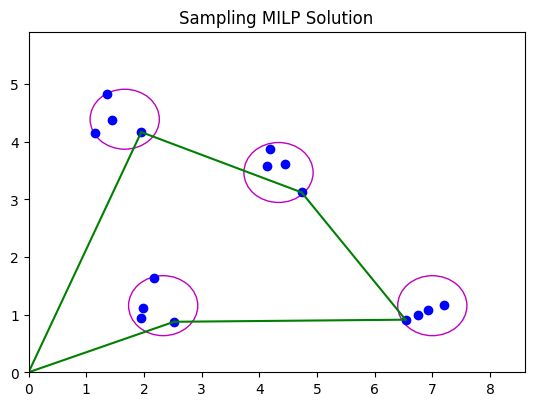

In [28]:
visualize_ellipses(start, alpha, T, mu, show=False, data=samples)

for edge in gtsp_path:
    u , v = edge[0], edge[1] # get the endpoints
    # find thier postions 
    positions = np.array([dg.nodes[u]['position'], dg.nodes[v]['position']])
    plt.plot(positions[:,0], positions[:,1], c='g')
plt.title('Sampling MILP Solution')
plt.show()


While the solution concept above produces a valid tour, the size of the MILP begins to become too large to solve as the number of sampled points (or the number of targets) grows large. To this end, we will now examine a second solution method to the Noon-Bean ATSP based on simulated annealing. 

Simulated Annealing, is a stochastic optimization method that randomly queries the search space to try to locate a global minima. The TSP is a classic application of simulated annealing [10], that we will also apply to our setting. We will apply the simulated annealing algorithm to the ATSP instances generated by the Noon-Bean transformation in an attempt to create a more scalable solution method for instances with large sample sizes.

The first step we need to apply is to again consider the ATSP graph as a complete graph, this is done the same way, i.e., adding all missing edges with at very large edge weight. The primary difference here is that we will actually update the structure of our networkx graph, rather than just modifying a distance matrix. This is mainly to ease the implementation of the annealing algorithm. 

In [29]:
# adds all missing edges to a digraph with theri weight being more than the sum of all other edge weights
# Parameters:
#   atsp_graph : a noonbean digraph
# Returns
#   A completed version of the input graph
def complete_atsp(atsp_graph: nx.DiGraph)-> nx.DiGraph:
    complete_graph = copy.deepcopy(atsp_graph)
    total_weight = 0
    for _, _, w in atsp_graph.edges(data="weight"):
        total_weight += (w+1)
    
    for u, v in nx.complement(atsp_graph).edges:
        complete_graph.add_edge(u, v, weight=total_weight)
    
    return complete_graph

complete_graph = complete_atsp(a_tsp)

The simulated annealing algorithm requires a random starting guess at a TSP tour. Since we are now dealing with a complete graph, this initial guess can be created by simply creating a random ordering of the graphs nodes. The following function creates such an initial tour given a graph input. We note that the function does not return a closed path, i.e., the last edge connecting the last node to the first is not directly specified meaning it must be considered later.

In [30]:
# intial path function
# Parameters:
#   graph : the graph to extract a route for
#   seed : an integer random seed
# Returns
#   a list of nodes that represents the order of the tsp path (first node not duplicated at end)
def inital_path(graph : nx.DiGraph, seed=None) -> list[int]:
    if seed is not None:
        random.seed(seed)
    nodes = list(graph.nodes)
    random.shuffle(nodes)
    return nodes

The key idea of simulated annealing is to randomly permute the initial guess in order to try to find a better solution. While there are several methods for permuting the path generated by the function above, one of the eaisest is simply to transpose two randomly selected indices of the graph. The following function generates such a permutation. 

In [31]:
# randomly transposes two nodes from a path list 
# parameters:
#   path : an ordered list of nodes representing a TSP tour
# returns:
#  path: a new path created by randomly switching two nodes in the input tour 
def transpose_path_nodes(path : list[int]) -> list[int]:
    i, j = random.sample(list(range(len(path))), 2) # randomly select two nodes 
    path[i], path[j] = path[j], path[i] # transpose them
    return path

After simulated annealing permutes the path, it first checks if the new path is better (shorter) than the old. The following function determines the length of an arbitraty path tour, taking into account the last edge from tail to head.

In [32]:
# determines the legth of a TSP tour based on a node list
# parameters:
#   graph: the graph to pull distance values from
#   path: the node list representing a tsp tour in a complete graph.
# returns:
#   the length of the corresponding tsp tour through the graph
def path_length(graph: nx.graph , path: list[int]) -> float:

    final_edge_length = graph[path[0]][path[-1]].get('weight', 1) # determine the length of the last edge in the tour
    return sum(graph[u][v].get('weight', 1) for u, v in itertools.pairwise(path)) + final_edge_length


After the tour length is calculated, one of two things can happen. If the tour is an improvement on the best tour seen so far, it is accepted as the new best tour and the next iteration begins. If, however, the tour length is not an improvement, the algorithm generates a random number uniformly $p \in (0,1]$. It then compares this random value to 
$$  e^{-\frac{1}{T}(\text{proposed tour length} - \text{current tour length})} $$

if $p$ is below this value, the worse tour is accepted anyway as the new working tour and the next iteration begins. 

The parameter $T$ in the expression above is known as the temperature of the simulated annealing algorithm. The algorithm is initialized with some value of $T$ representing the initial temperature of the system. As the algorithm progresses the value of $T$ is gradually decreased according to some cooling schedule. Notice in the function above that the value of $T$ partially controls the acceptance probability. When $T$ is large compared to the difference in tour length, the expression goes to 1. However, as $T$ becomes smaller, the probability of accepting a worse tour goes to 0.

There are several choices of cooling schedules discussed in class. The following functions implement three of them.


In [33]:
# cooling functions for simulated annealing, all accept a hyperparameter a to control the rate as a parameters, but it is not always used.
def exponential_cooling(t, i, a):
    return t * (a**i)

def fast_cooling(t, i, a):
    return t/i

def log_cooling(t, i, a):
    return t * (np.log(2)/np.log(i+2))

With all of the preliminaries covered, we turn to the implementation of the simulated annealing algorithm.

In [34]:
# Simmulated Annealing Algorithm for TSP
# Parameters:
#   graph: a complete graph obtained from the NB transformation
#   n_iters: number of interations the algorithm shuld run for
#   initial_temperature: the initial temperature value of the system
#   cooling schedule: a function accepting the initial temperature, the current iteration, and a parameter alpha that gives the temperature
#                     for the current iteration
#   alpha: a hyperparameter in (0,1) for the cooling function
#   value_list: wether to store the intermediate values of the tour the algorithm considers
# Returns:
#   An edge view tsp path through the graph
#   The length of the path
#   (optional) a list of intermediate path lengths
def TSP_simulated_annealing(graph: nx.DiGraph, 
                            n_iters: int, 
                            initial_temperature: float, 
                            cooling_schedule: Callable, 
                            alpha: float,
                            value_list=True) -> tuple[list[tuple[int,int]], float]:
    # at time 0, our best solution is a random path through the graph
    best_path = inital_path(graph)
    # calculate its cost
    best_cost = path_length(graph, best_path)
    current_iter = 0
    if value_list:
        values = []
    
    # this is that path that can change stochastically 
    working_path = copy.deepcopy(best_path)
    working_cost = best_cost

    while current_iter <= n_iters:
        current_iter += 1

        # create a new proposed path
        proposed_path = transpose_path_nodes(copy.copy(working_path))
        proposed_cost = path_length(graph, proposed_path)
        if value_list:
            values.append(proposed_cost)
        # calculate the temperature for the current iteration
        temperature = cooling_schedule(initial_temperature, current_iter, alpha)

        # caluclate the cost difference for the current iteration
        cost_difference = proposed_cost - working_cost

        # if our temperature goes below zero somehow break the loop early
        if temperature <= 0:
            break

        # if the  proposed path is better than the working path make it the new working path
        if cost_difference <= 0:
            working_cost = proposed_cost
            working_path = proposed_path.copy()
        else:
            # accept a worse path with some probability 
            if np.exp(-cost_difference / temperature) >= random.random():
                # print(f'accept {temperature}' )
                working_cost = proposed_cost
                working_path = proposed_path.copy()
        
        # check if the current working path is the best we have seen so far, if so save it 
        if working_cost <= best_cost:
            # print(best_cost)
            best_cost = working_cost
            best_path = working_path.copy()
    
    # after the annealing process return the best path as an edge view 
    best_path += [best_path[0]] # duplicate the first node so the node list form a tour
    best_path = [tuple(x) for x in itertools.pairwise(best_path)]

    if value_list:
        return best_path, best_cost, values
    return best_path, best_cost



We can now try out simulated annealing process for several choices of cooling schedules. There is no known way to determine a good starting temperature for simulated annealing. We will the average path length in out complete ATSP graph over 50 random TSP tours. Recall that in the noon-bean complete graph, many edges have been scaled to large lengths so we expect this value to be large. 

In [35]:
starting_temperature = np.average([path_length(complete_graph, inital_path(complete_graph)) for _ in range(50)])
print(f'Starting temperature: {starting_temperature}')

Starting temperature: 454841.74796147196


We will first try the exponential cooling with $\alpha=0.9$ scheme for 5000 iterations.

In [56]:
path, cost, values = TSP_simulated_annealing(complete_graph, 5000, starting_temperature, exponential_cooling, 0.9)


The best cost path (converted back to the original frame) is given by:

In [57]:
gtsp_tour = recover_path(path, n_clusters)
print(gtsp_tour)
print(f'Path cost in original digraph: {path_length(dg, [h[0] for h in gtsp_tour])}')

[(0, 12), (12, 6), (6, 3), (3, 15), (15, 0)]
Path cost in original digraph: 20.05512586907313


We now repeat the same process but with the other cooling schedules. First, the fast cooling method.

In [38]:
path, cost, values = TSP_simulated_annealing(complete_graph, 5000, starting_temperature, fast_cooling, 0.9)
gtsp_tour = recover_path(path, n_clusters)
print(gtsp_tour)
print(f'Path cost in original digraph: {path_length(dg, [h[0] for h in gtsp_tour])}')

[(0, 15), (15, 5), (5, 4), (4, 9), (9, 0)]
Path cost in original digraph: 17.873020128314447


And, finally, the log cooling method

In [39]:
path, cost, values = TSP_simulated_annealing(complete_graph, 5000, starting_temperature, log_cooling, 0.9)
gtsp_tour = recover_path(path, n_clusters)
print(gtsp_tour)
print(f'Path cost in original digraph: {path_length(dg, [h[0] for h in gtsp_tour])}')

[(0, 10), (10, 8), (8, 12), (12, 15), (15, 7), (7, 9), (9, 5), (5, 2), (2, 0)]
Path cost in original digraph: 32.58541667203856


Notably, all three cooling schedules produce worse tours than even the single sample method. With the log cooling schedules producing a particularly poor tour. However, despite this, the fast cooling in particular is only slightly worse MILP GTSP solution and does not require an MILP solution to produce its answer. We also note that simulated annealing is highly sensitive to the initial temperature, so further testing will be needed to see the true performance of the method. Furthermore, as the method is stochastic, multiple runs may produce different tour values.

#### Part 3: Graphs of Convex Sets

The final approach we will observe is using the concept of a Graph of Convex Sets (GCS) as presented in [5,6]. In this approach, the entire neighborhood  of the ellipse can be considered without the need for sampling allowing for a nearly exact solution. What follows is a brief summary of the theory behind a graph of convex sets. Most of the heavy lifting code wise will be handled by the ``gcsopt`` package [6].

The key idea of the graph of convex sets  approach [5] (in 2 dimensions), is to add new optimization variables for the $x_{v}$ and $y_{v}$ coordinates of each vertex $v$. These variables are then constrained to fall within a convex set $\mathcal{X}_{v}$ corresponding to that vertex. Then, for each edge in the graph $(u,v)$ its weight is constrained to equal the Euclidean distance between $(x_{u},y_{u})$ and $(x_{v}, y_{v})$. Several transformations are applied to this basic formulation, namely working with the perspective of the convex set rather than the set itself, to allow problems to be solved efficiently. However, at a basic level, a typical TSP formulation can just be augmented with these additional constraints and solved to obtain the final solution. The end result of a GCS formulation of TSP is a mixed-integer convex program (MICP), which shares many commonalities with the MILP's we have looked at so far, but the objective function is only required to be a convex function (as opposed to linear).

Much of the work implementing the TSP in GCS formulation is done for us already by ``gcsopt``, but the one set we do need to specify is the structure of our graph. Specifically, we need to define variables for the coordinates of each vertex and the convex set that these coordinates must fall in. We will have one vertex in the GCS for each of our ellipses, and use the ellipses as the convex set constraints. Formally, for each ellipse $\mathcal{E}$ with center $(e_{x}, e_{y})$, semi-major axis $a$, and semi minor axis $b$, we introduce a pair of variables
$$ \mathbf{x} = \left [ 
        \begin{array}{c}
        x_{v}  \\
        y_{v} \\
        \end{array}
    \right ]$$
and the constraint 
$$ \mathbf{x} \in \mathcal{E} $$
which is mathmatically represented by the following constraint
$$ || A_{\mathcal{E}}(\mathbf{x}-c_{\mathcal{E}}) ||_{2} \leq 1 $$
Where 
$$ 
A_{\mathcal{E}} = \left [ 
        \begin{array}{cc}
            \frac{1}{a} & 0\\
            0 & \frac{1}{b}\\
        \end{array}
    \right ]
$$
and 
$$ c_{\mathcal{E}} = \left [ 
        \begin{array}{c}
        e_{x}  \\
        e_{y} \\
        \end{array}
    \right ]$$

The following code implements the vertices of our graph of convex sets for the example problem.

In [58]:
alpha = 0.9
T = 0.5
mu = 0.5 
major_axis = (alpha*T) / (1- (mu**2))
minor_axis = (alpha*T) / np.sqrt((1- (mu**2)))
ellipse_centers = np.zeros(start.shape)
ellipse_centers[:,0] = (start[:,0] + (mu*T)) / (1- (mu**2))
ellipse_centers[:,1] = start[:,1] / np.sqrt((1- (mu**2)))

GCS = GraphOfConvexSets(directed=False)

for ellipse in range(ellipse_centers.shape[0]):
    v = GCS.add_vertex(ellipse+1) # create a new vertex named after the ellipse
    x = v.add_variable(2) # add the x and y variables for the vertex position
    A = np.diag([1/major_axis, 1/minor_axis]) # create the A matrix for the ellipse
    center = np.array([ellipse_centers[ellipse, 0] , ellipse_centers[ellipse, 1]]) # the center vector
    v.add_constraint(cp.norm2(A @ (x - center)) <= 1) # add the convex set constraint for the ellipse


We then add one additional vertex to represent the starting point of the pursuer. Unlike the other vertices, the convex set here is a singleton, only containing the origin.

In [59]:
v = GCS.add_vertex(0) # this will be vertex 0
x = v.add_variable(2)
v.add_constraint(cp.norm2(x) <= 0)

We now add the edges to the GCS. Since the neighborhoods can be visited in any order, we add all possible edges between vertices. For each edge, $(u,v)$, we create a constraint that sets the edge length to
$$ || \mathbb{x}_{u} - \mathbb{x}_{v} ||_{2}, $$
i.e., the euclidean distance between the coordinates of the endpoints.

In [60]:
for i, v in enumerate(GCS.vertices): # i is the index of the vertex v
    u_s = GCS.vertices[i + 1:] # list of all the neighbours of v that do not have an edge yet
    for u in u_s: 
        if v != u: # do not add self loops

            edge = GCS.add_edge(u,v) # add the edge to the graph
            pos_u = u.variables[0] # position variable for u
            pos_v = v.variables[0] # position variable for v
            edge.add_cost(cp.norm2(pos_v - pos_u)) # add the edge cost constraint

This gives us the following graph structure

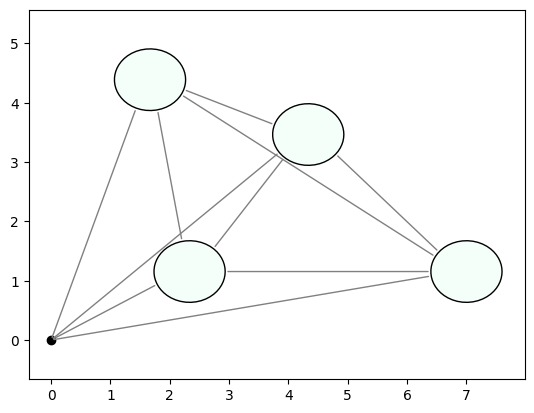

In [61]:
plt.figure()
plt.axis("equal")
GCS.plot_2d()
plt.show()

We can now use `gcsopt` to solve TSP in the graph of convex sets

In [62]:
GCS.solve_traveling_salesman(subtour_elimination=True, binary=True)
print(f'Problem status from solver: {GCS.status}')
print(f'Optimal tour length: {GCS.value}')


Problem status from solver: optimal
Optimal tour length: 16.158840005983354


We see that this tour length is the best achieved so far, achieving an improvment over the sample-based methods by about 1 unit. We can how use `gcsopt` to visualize the final path extracted.

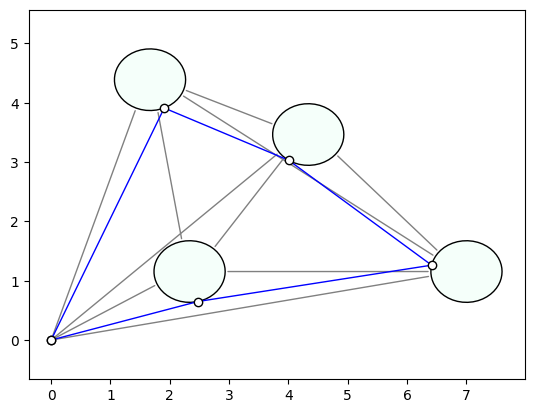

In [63]:
plt.figure()
plt.axis("equal")
GCS.plot_2d()
GCS.plot_2d_solution()
plt.show()

While the GCS method produces the best tour, it is important to note that it comes at a high computational cost. MICP's are in general harder problems than MILP's meaning that the GCS approach likely will not scale beyond a small number of cities. 

Before we present our final set of results, we define several functions that will allow us to employ each of the techniques covered here on arbitrary problem instances 

In [112]:
# given a cost matrix C solve the MTZ formulation of TSP corresponding to C
# Parameters:
#   C: numpy cost matrix of size n x n
# Returns:
#   X: binary matrix represention of a TSP tour
def solve_MZT_TSP(C : np.ndarray) -> np.ndarray:
    X = cp.Variable(C.shape, boolean=True)

    objective_function = cp.Minimize(cp.sum(cp.multiply(C, X)))
    constraints = []
    ones_vector = np.ones((C.shape[0], 1))
    constraints.append(X @ ones_vector == ones_vector) 
    constraints.append(X.T @ ones_vector == ones_vector) 
    constraints.append(cp.diag(X) == 0) 

    n = C.shape[0]

    #  now add the new t varaibles and constraints 
    t = cp.Variable(n)
    constraints.append(t[0] == 1) # time for the first city is 1
    constraints.append(t[1:] <= n) # t2 ... tn <= n
    constraints.append(t[1:] >= 2) # t2 ... tn >= 2

    # now add the increasing time constraints for all distinct pairs of i and j
    for i in range(1, n):
        for j in range(1, n):
            if i != j:
                constraints.append(t[i]- t[j] + 1 <= (n-1)*(1-X[i,j]))
 
    program = cp.Problem(objective_function, constraints) # define the program with cvxpy
    program.solve('MOSEK', verbose=False) # solve using the MOSEK solver

    return X.value

# Ellipse center Solution Method
# Parameters: 
#   starting points: a numpy arry of size nx2 representing the starting locations of the n targets
#   alpha: The velocity of the interceptor 
#   T: Time required by interceptor to hit target
#   mu: The velocity of of the target, mu < alpha
# Returns: 
# optimal path length of tsp tour through the static ellipse centers
def ellipse_center_method(starting_points: np.ndarray, alpha : float, T: float, mu: float) -> float:
    # get circle centers and radius
    centers, radius = get_init_capture_circles(starting_points, alpha, T, mu)
    static_locations = static_frame_transform([centers], mu) # transform the circle centers we found before to the elliptical setting
    static_locations = static_locations[0]
    # add the origin as a city
    starting_point = np.zeros((1,2))
    static_locations = np.vstack((starting_point, static_locations))
    C = find_c_matrix(static_locations)

    x_matrix = solve_MZT_TSP(C)

    return np.sum(C*x_matrix)

# Sampling Method using Noon Bean and MTZ
# Parameters: 
#   starting points: a numpy arry of size nx2 representing the starting locations of the n targets
#   alpha: The velocity of the interceptor 
#   T: Time required by interceptor to hit target
#   mu: The velocity of of the target, mu < alpha
#   number_samples: the number of points to sample for each circle
# Returns: 
# optimal path length of GTSP tour through samples
def sampling_MTZ_method(starting_points: np.ndarray, alpha : float, T: float, mu: float, number_samples: int) -> float:
    centers, radius = get_init_capture_circles(starting_points, alpha, T, mu)
    samples = circle_sample(centers, radius, number_samples)
    # print(samples)
    samples = static_frame_transform(samples, mu)
    # print(samples)
    dg, n_clusters = generate_digraph_representation(samples) # create the digraph
    # print(len(dg.nodes))
    a_tsp = noon_bean_transformation(dg, n_clusters )
    # print(len(a_tsp.nodes))
    C = to_adjacency_matrix(a_tsp)
    # print(C.shape)
    X_matrix = solve_MZT_TSP(C)
    path_ind= np.argwhere(X_matrix >= 0.5)
    # print(path_ind)
    path = recover_path(path_ind, n_clusters)
    return sum(dg[u][v].get('weight',1) for u, v in path)

# Sampling Method using Simulated Annealing
# Parameters: 
#   c_atsp: the complete ATSP graph from the NB transformation
#   +
#   simulated annealing params
# Returns: 
# path length of GTSP tour through samples
# optional: list of simulated annealing values
def sampling_SimA_method(c_atsp : nx.DiGraph,
                          temperature0: float,
                          max_iter: int,
                          cooling_schedule: Callable,
                          cooling_parameter=None,
                          return_values = True
                          ) -> float:
    # centers, radius = get_init_capture_circles(starting_points, alpha, T, mu)
    # samples = circle_sample(centers, radius, number_samples)
    # samples = static_frame_transform(samples, mu)
    # dg, n_clusters = generate_digraph_representation(samples) # create the digraph
    # a_tsp = noon_bean_transformation(dg, n_clusters )
    # c_atsp = complete_atsp(a_tsp)
    path, cost, values = TSP_simulated_annealing(c_atsp, max_iter, temperature0, cooling_schedule, cooling_parameter, value_list=True)
    path = recover_path(path, n_clusters)
    if return_values:
        return sum(dg[u][v].get('weight',1) for u, v in path), values
    else:
        return sum(dg[u][v].get('weight',1) for u, v in path)
    

# GCS solution method
# Parameters ... see above
def gcs_method(starting_points: np.ndarray, alpha : float, T: float, mu: float) -> float:
    major_axis = (alpha*T) / (1- (mu**2))
    minor_axis = (alpha*T) / np.sqrt((1- (mu**2)))
    ellipse_centers = np.zeros(starting_points.shape)
    ellipse_centers[:,0] = (starting_points[:,0] + (mu*T)) / (1- (mu**2))
    ellipse_centers[:,1] = starting_points[:,1] / np.sqrt((1- (mu**2)))

    GCS = GraphOfConvexSets(directed=False)

    for ellipse in range(ellipse_centers.shape[0]):
        v = GCS.add_vertex(ellipse+1) # create a new vertex named after the ellipse
        x = v.add_variable(2) # add the x and y variables for the vertex position
        A = np.diag([1/major_axis, 1/minor_axis]) # create the A matrix for the ellipse
        center = np.array([ellipse_centers[ellipse, 0] , ellipse_centers[ellipse, 1]]) # the center vector
        v.add_constraint(cp.norm2(A @ (x - center)) <= 1) # add the convex set constraint for the ellipse

    v = GCS.add_vertex(0) # this will be vertex 0
    x = v.add_variable(2)
    v.add_constraint(cp.norm2(x) <= 0)

    for i, v in enumerate(GCS.vertices): # i is the index of the vertex v
        u_s = GCS.vertices[i + 1:] # list of all the neighbours of v that do not have an edge yet
        for u in u_s: 
            if v != u: # do not add self loops

                edge = GCS.add_edge(u,v) # add the edge to the graph
                pos_u = u.variables[0] # position variable for u
                pos_v = v.variables[0] # position variable for v
                edge.add_cost(cp.norm2(pos_v - pos_u)) # add the edge cost constraint
    GCS.solve_traveling_salesman(subtour_elimination=True, binary=True)

    return GCS.value

    
    

## Results

The primary goal of this project is to compare the quality and scalability of each of the methods presented above. The first comparison we will make is the effect of the sample size on quality of the tour produced and the time of the calculation when we solve optimally using the MTZ programs. To this end, we will fix the problem instance to the example we have been working with so far. We then compare the average tour length found across ten runs for sample sizes of $m \in [2,6]$. The expectation is that we will see a decrease in the length of the tour as the sample size increases.


In [ ]:
# Problem Instance Data
start = np.array([
        [5,1],
        [3,3],
        [1.5,1],
        [1,3.8]
    ])
alpha = 0.9
T = 0.5
mu = 0.5 
centers, radius = get_init_capture_circles(start, alpha, T, mu)


avg_weights = []
for sample_size in [2,3,4,5,6]:
    data = []
    for trial in tqdm(range(10)):
        tour_length = sampling_MTZ_method(start, alpha, T, mu, sample_size)
        data.append(tour_length)
    avg_weights.append(sum(data)/len(data))
    
for i, weight in enumerate(avg_weights):
    print(f'Sample Size: {i+2}  Average Path Length: {float(weight)}')

plt.plot(list(range(2,7)), avg_weights, c='r')
plt.scatter(list(range(2,7)), avg_weights, c='r')
plt.xticks(list(range(2,7)))
plt.xlabel('Samples per Ellipse')
plt.ylabel('GTSP Length')
plt.title('Effect of Sample Size on Tour Length')


100%|██████████| 10/10 [00:14<00:00,  1.48s/it]

Sample Size: 2  Average Path Length: 17.804638259193094
Sample Size: 3  Average Path Length: 17.635633466705293
Sample Size: 4  Average Path Length: 17.02817379193621
Sample Size: 5  Average Path Length: 16.989480031657138
Sample Size: 6  Average Path Length: 16.882238365951697


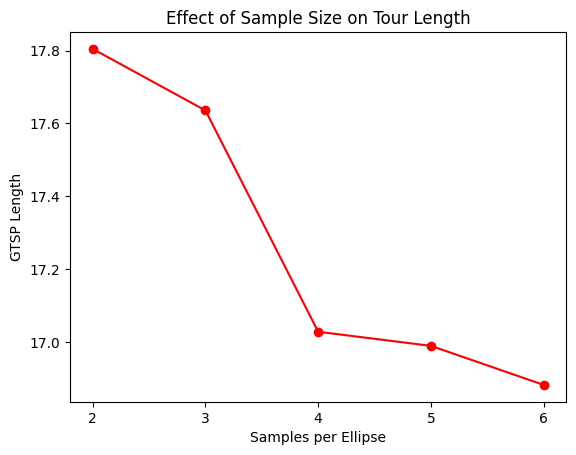

In [111]:
plt.plot(list(range(2,7)), avg_weights, c='r')
plt.scatter(list(range(2,7)), avg_weights, c='r')
plt.xticks(list(range(2,7)))
plt.xlabel('Samples per Ellipse')
plt.ylabel('GTSP Length')
plt.title('Effect of Sample Size on Tour Length')
plt.show()

We see that, at least for this small number of trials, our intuition does appear to hold. Increasing the number of samples within each ellipse leads to a better over all tour. However, we note that this trend is likely highly sensitive to the specific choice of samples, as even a large number of samples could lead to a poor tour if none of the samples align with the true valid points within the tour.

Our next result will examine how well our simulated annealing sampling approach works for solving the problem. Again we will work with our example problem's ellipses and test the effect of different starting temperatures and cooling schedules on the optimization process. As the work above appears to indicate that a greater number of samples yields a better tour, we will again sample 6 points within each ellipse. We will test the exponential ($\alpha=0.9$) and fast cooling schedules as they performed best before. We will study three different starting temperatures again based on the average path length over 50 random paths. The first starting temperature will just be this average value. The second and third will subtract and add one standard deviation to this average respectively. We will use the same samples for each combination of parameters and report the minimum path found after 10 runs of the algorithm. The annealing will be run for a maximum of 4000 iterations

In [118]:
### create the inital complete atsp graph
centers, radius = get_init_capture_circles(start, alpha, T, mu)
samples = circle_sample(centers, radius, m=6)
samples = static_frame_transform(samples, mu)
dg, n_clusters = generate_digraph_representation(samples) # create the digraph
a_tsp = noon_bean_transformation(dg, n_clusters )
c_atsp = complete_atsp(a_tsp)

random_path_lengths = [path_length(c_atsp, inital_path(c_atsp)) for _ in range(50)]
average_path_length = np.mean(random_path_lengths)
std = np.std(random_path_lengths)

for cooling_schedule in [('Fast Cooling', fast_cooling), ('Exponential Cooling', exponential_cooling)]:
    for t0 in [('Agerage', average_path_length), ('Agerage + Std', average_path_length + std), ('Agerage - Std', average_path_length - std)]:
        param_path_lengths = []
        for _ in range(10):
            w = sampling_SimA_method(c_atsp=c_atsp, temperature0=t0[1], max_iter=5000, cooling_schedule=cooling_schedule[1], cooling_parameter=0.9, return_values=False)
            param_path_lengths.append(w)
        print(f'Cooling Schedule: {cooling_schedule[0]}  Starting Temp: {t0[0]}  Best Path {min(param_path_lengths)}')


Cooling Schedule: Fast Cooling  Starting Temp: Agerage  Best Path 33.31573783797239
Cooling Schedule: Fast Cooling  Starting Temp: Agerage + Std  Best Path 48.644447689192816
Cooling Schedule: Fast Cooling  Starting Temp: Agerage - Std  Best Path 17.125792685196817
Cooling Schedule: Exponential Cooling  Starting Temp: Agerage  Best Path 27.076618036580342
Cooling Schedule: Exponential Cooling  Starting Temp: Agerage + Std  Best Path 24.814637391904096
Cooling Schedule: Exponential Cooling  Starting Temp: Agerage - Std  Best Path 22.238889891715168




This small set of trials appears to indicate that the exponential cooling schedule gives better result **on average** than the fast cooling schedules. Across both schedules, using the lower starting temperature appears to give slightly better results. This is particularly evident in the third trial that finds a path length around 17, but the 6th trial also shows an improvement. This being said, it does not appear that any of these methods uniformly generates a good solution. This is likely because the number of valid tours in a TSP scales factorially with the number of cities and our objective function is highly non-convex. This means that our algorithm is unlikely to ever converge onto a true minimum. T

As a final analysis of the quality of our solution methods, we will compare them directly by attempting to solve randomly generated problem instances of varying sizes. The comparison will be done as follows. We will attempt to solve our pursuit problem for a number of targets $n \in \{3, \dots, 10\}$. We will first apply the upper bound procedure  using the ellipse centers. We will then apply the GCS formulation which should, in theory, produce the best results. For the sampling-based methods (MTZ and Annealing), the sample size will be 4 points in each ellipse to keep the total number of cities manageable for these methods. For the simulated annealing, we will use the best parameters from above: Fast cooling schedule with a starting temperature based on the average path length minus one standard deviation. Due to the inherent instability of the method, we will use the best run of 10 trials for simulated annealing. The starting locations for the targets will be sampled uniformly at random from $[0,10]\times[0,10]$. We will continue to use the parameters of $\mu$, $\alpha$, and $T$ from our example problem.

In [121]:
single_point_lengths = []
mtz_sample_lengths = []
sa_sample_lengths = []
gcs_lengths = []

for num_ellipses in tqdm(range(3, 11)):
    start_points = np.random.uniform(low=0, high=10, size=(num_ellipses, 2))

    # upper bound
    weight = ellipse_center_method(start_points, alpha, T, mu)
    single_point_lengths.append(weight)

    # GCS
    weight = gcs_method(start_points, alpha, T, mu)
    gcs_lengths.append(weight)

    # MTZ samples
    weight = sampling_MTZ_method(start_points, alpha, T, mu, number_samples=4)
    mtz_sample_lengths.append(weight)

    # simulated annealing 
    centers, radius = get_init_capture_circles(start_points, alpha, T, mu)
    samples = circle_sample(centers, radius, m=4)
    samples = static_frame_transform(samples, mu)
    dg, n_clusters = generate_digraph_representation(samples) 
    a_tsp = noon_bean_transformation(dg, n_clusters )
    c_atsp = complete_atsp(a_tsp)
    random_path_lengths = [path_length(c_atsp, inital_path(c_atsp)) for _ in range(50)]
    t0 = np.mean(random_path_lengths) - np.std(random_path_lengths)

    m_trials = []
    for _ in range(10):
        weight = sampling_SimA_method(c_atsp, t0, 5000, exponential_cooling, cooling_parameter=0.9, return_values=False)
        m_trials.append(weight)
    sa_sample_lengths.append(min(m_trials))
    


100%|██████████| 8/8 [01:16<00:00,  9.62s/it]


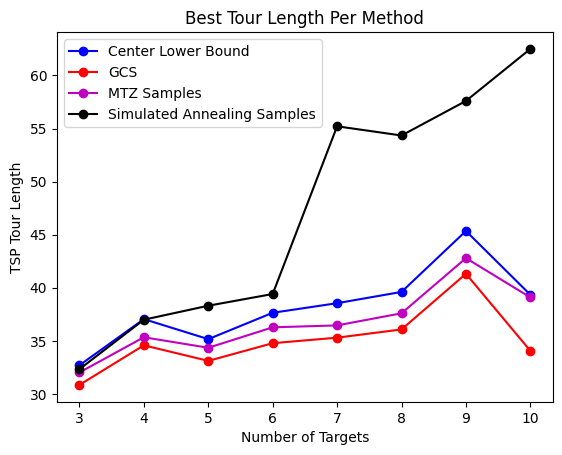

In [128]:
# visualize results
x_s = list(range(3,11))
# print(x_s)
# print(len(single_point_lengths))
plt.plot(x_s, single_point_lengths, linestyle='-', marker='o', c='b', label='Center Lower Bound')
plt.plot(x_s, gcs_lengths, linestyle='-', marker='o', c='r', label='GCS')
plt.plot(x_s, mtz_sample_lengths, linestyle='-', marker='o', c='m', label='MTZ Samples')
plt.plot(x_s, sa_sample_lengths, linestyle='-', marker='o', c='k', label='Simulated Annealing Samples')
plt.xticks(x_s)
plt.xlabel('Number of Targets')
plt.ylabel('TSP Tour Length')
plt.title('Best Tour Length Per Method')
plt.legend()
plt.show()


The figure above is illustrative of a trend we saw in the methods section. The GCS method provides the best tour of any method for all numbers of ellipses. The sampling methodology solved as an MILP using the MTZ constraints provides the second best results, typically falling only a few units higher than the tours produced by GCS. Interestingly, the upper bound produced by only considering the center of each ellipse gives a fairly competitive tour, typically only slightly worse than the much more computationally expensive MILP sampling strategy. By far the least competitive method is simulated annealing, even given the benefit of multiple trials, it performs the worst of any method for all but the case of 3 targets. In particular, we see that as the number of targets increases to 7, the tour produced by simulated annealing is more than 20 units higher than even the "upper bound".

The second metric we wanted to judge our methodologies on is scalability. Anecdotally while developing this project, the methods in order from least to most scalable appears to be: sampling MILP, GCS, center sampling, and simulated annealing. However, to empirically test this we will run each method on randomly generated problem instances of three different sizes, 3 targets, 5 targets, and 10 targets. For each problem size, we will run 5 trials of each and report the average time. For the two sample based methods, we will use the same parameters as in the previous experiment.

In [ ]:
# This block takes approximately 20 minutes to run on a fairly powerful machine. I do not recomend running it 
# The code is not commented as this is just repeats from earlier inside a loop
sps = []
for problem_size in [3, 5, 10]:
    sp_time = []
    for _ in tqdm(range(10)):
        start_points = np.random.uniform(low=0, high=10, size=(problem_size, 2))
        start_time = time.perf_counter()
        weight = ellipse_center_method(start_points, alpha, T, mu)
        end_time = time.perf_counter()
        sp_time.append(end_time-start_time)
    sps.append(float(np.mean(sp_time)))


gcss = []
for problem_size in [3, 5, 10]:
    gcs_time = []
    for _ in tqdm(range(10)):
        start_points = np.random.uniform(low=0, high=10, size=(problem_size, 2))
        start_time = time.perf_counter()
        weight = gcs_method(start_points, alpha, T, mu)
        end_time = time.perf_counter()
        gcs_time.append(end_time-start_time)
    gcss.append(float(np.mean(gcs_time)))

sas = []
for problem_size in [3, 5, 10]:
    sa_time = []
    for _ in tqdm(range(10)):
        start_points = np.random.uniform(low=0, high=10, size=(problem_size, 2))
        start_time = time.perf_counter()
        centers, radius = get_init_capture_circles(start_points, alpha, T, mu)
        samples = circle_sample(centers, radius, m=4)
        samples = static_frame_transform(samples, mu)
        dg, n_clusters = generate_digraph_representation(samples) 
        a_tsp = noon_bean_transformation(dg, n_clusters )
        c_atsp = complete_atsp(a_tsp)
        random_path_lengths = [path_length(c_atsp, inital_path(c_atsp)) for _ in range(50)]
        t0 = np.mean(random_path_lengths) - np.std(random_path_lengths)
        weight = sampling_SimA_method(c_atsp, t0, 5000, exponential_cooling, cooling_parameter=0.9, return_values=False)
        end_time = time.perf_counter()
        sa_time.append(end_time-start_time)
    sas.append(float(np.mean(sa_time)))

milps = []
for problem_size in [3, 5, 10]:
    milp_time = []
    for _ in tqdm(range(10)):
        start_points = np.random.uniform(low=0, high=10, size=(problem_size, 2))
        start_time = time.perf_counter()
        weight = sampling_MTZ_method(start_points, alpha, T, mu, number_samples=4)
        end_time = time.perf_counter()
        milp_time.append(end_time-start_time)
    milps.append(float(np.mean(milp_time)))
        

100%|██████████| 10/10 [18:35<00:00, 111.57s/it]


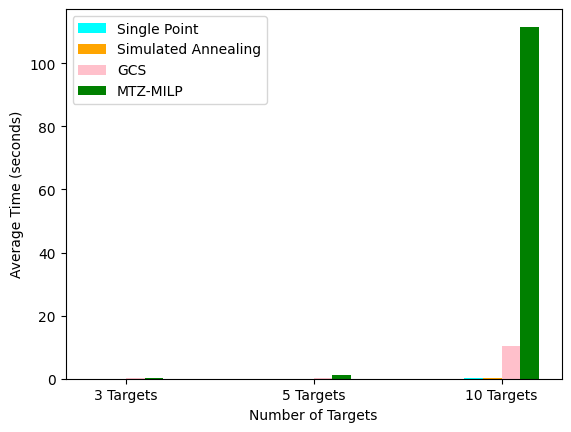

In [142]:
x = np.array([1, 2, 3])
# three_cities = [sps[0], gcss[0], sas[0], milps[0]]
# five_cities = [sps[1], gcss[1], sas[1], milps[1]]
# ten_cities = [sps[2], gcss[2], sas[2], milps[2]]
bar_width = 0.1
plt.bar(x-0.15, sps, bar_width, color='cyan')
plt.bar(x-0.05, sas, bar_width, color='orange')
plt.bar(x+0.05, gcss, bar_width, color='pink')
plt.bar(x+0.15, milps, bar_width, color='green')
plt.xticks(x, ['3 Targets', '5 Targets', '10 Targets'])
plt.xlabel('Number of Targets')
plt.ylabel('Average Time (seconds)')
plt.legend(['Single Point', 'Simulated Annealing', 'GCS', 'MTZ-MILP'])
plt.show()

As is evident from the bar plot above, the average time of  execution  is relatively fast for all methods except the sample-based MTZ approach. This is to be expected as the MILP is being effectivly solved for 40 cities when there are 10 targets and the TSP is NP-hard. 

This concludes the main results of this project. We will next turn to a brief discussion of the results and a retrospective of the project as a whole.

## Discussion and Conclusion

To conclude, in this project we examined 3 strategies for solving a generalized travelling salesman problem inspired by a heterogeneous pursuit problem: single point solutions, multiple point sampling, and graphs of convex sets. The primary optimization tools we used to solve this problem were mixed integer linear programming, mixed integer convex programming, and simulated annealing. The goal of this project was to compare these three methods in terms of both the quality of their solutions and their scalability to large problem instances. 

In terms of the quality of tour produced, the graph of convex sets approach is by far the best method we tested, typically producing a tour that was 2 or 3 units better than the next best method across all trials. Beyond this, the multiple point sampling method solved using a MILP produced the next best results, followed by the single point method. In general, these three methods performed similarly to each other, with the difference in tour length between the GCS (best) and single point (third worst) typically being only about 4 units (for tours with optimal path lengths around 30 to 40). That is the gulf between the best and worst of these three solution was only about 10%. Thus, while the GCS approach performs best, the other methods may be viable if high accuracy is not needed. The commonality between these three methods, is their reliance on solving integer programming to produce a solution. This guarantees a degree of optimality from these solutions, with deviation from the optimum only being as result of the choice of city locations. 

The only method we employed that did not incorporate  integer programming was using simulated annealing to solve the multiple point sampling formulation of the problem. Our results show that this method does not typically produce a good tour. Indeed, aside from a single case, it performs the worst of any solution method tested, at worst producing a tour more than double that of the GCS solution for the same instance. Another observation we can make specifically of the MILP solution to the multi-point sampling method is the effect of the sample size within each neighborhood. We observe that sampling a larger number of points in each neighbourhood on average leads to a more optimal tour. Thus, in terms of quality, any of the solution methods demonstrated in this project except for simulated annealing is likely viable, with GCS performing the best overall. 

In terms of scalability, we found that the performance of each method is largely dependent on the problem size. For problem instances with only a small number of cities (3), all methods can compute the optimal solution in less than a second. However, as the number of targets increases, we begin to see a significant increase in the solution time for the GCS and MILP multi-point sampling solutions. For instance, we see that the optimal solution for a 10 city instance takes GCS on average 10 seconds to solve and the MILP over a 4 point sample more than 100 seconds to solve. On the other hand, the single point and the simulated annealing methods scale well to these larger instances having average runtimes of around 1 second. We feel that it is important to note that the runtime of the MILP solution to the multi-point sampling method is highly sensitive to the number of sampled points. This is because, at a sample size of 4 for 10 targets, the MILP is effectively  solving a TSP over 40 cities. Comparing this to the single point solution, which would only be considering a 10 city problem, obviates the reason behind the slow runtime of the multi-point sample MILP. 

In summation, the graph of convex sets approach produces the best tours in terms of quality, but does have a moderate scalability concern for larger problem instances. In general though, this method is the best we tested offering excellent results and relatively fast speeds. The single point method solved with an MILP, scales well to larger instances, but produces a notably worse tour than other methods. This method may then be applicable in situations where only a near-optimal solution is needed and real-time calculation is essential. The sampling based MILP approach, performs relatively well but scales very poorly to larger instances, especially when the sample size is large. Thus, it may only be suitable in cases where the  neighborhoods are small, and few samples are needed to produce a good coverage of the region. The simmulated annealing method appears to produce arbitrarily bad tours for a given instances, making it unsuitable for any application where an optimal or near-optimal solution is required. However, the method does run extremely fast, even for the largest of instances, perhaps giving it an  application in situation where a real-time, low accuracy estimation of the optimal tour is needed.

In retrospect for the project, choosing an NP-Hard problem likely increased my workload significantly especially as one of the solution methods I wanted to employ required a specialized solver. I also would have like to have time to explore better heuristic solutions to the TSP such as LKH [11] or the classic Christofides heuristic [12].


### References

[1] $\quad$ P. Surve, R. L. Frost, S. D. Bopardikar, A. Von Moll, and D. W. Casbeer, “Heterogeneous pursuit of multiple translating targets,” in *2025 IEEE Conference on Control Technology and Applications (CCTA)*, pp. 507–512, IEEE, 2025.

[2] $\quad$ M. R. Garey and D. S. Johnson, *Computers and intractability*, vol. 29. wh freeman New York, 2002.

[3] $\quad$ P. C. Pop, O. Cosma, C. Sabo, and C. P. Sitar, “A comprehensive survey on the generalized traveling salesman problem,” *European Journal of Operational Research*, vol. 314, no. 3, pp. 819–835, 2024.

[4] $\quad$ C. E. Noon and J. C. Bean, “An efficient transformation of the generalized traveling salesman problem,” *INFOR: Information Systems and Operational Research*, vol. 31, no. 1, pp. 39–44, 1993.

[5] $\quad$ T. Marcucci, J. Umenberger, P. Parrilo, and R. Tedrake, “Shortest paths in graphs of convex sets,” *SIAM Journal on Optimization*, vol. 34, no. 1, pp. 507–532, 2024.

[6] $\quad$ T. Marcucci, “A unified and scalable method for optimization over graphs of convex sets,” *arXiv: 2510.20184* 2025.

[7] $\quad$ C. E. Miller, A. W. Tucker, and R. A. Zemlin, “Integer programming formulation of traveling salesman problems,” *Journal of the ACM (JACM)*, vol. 7, no. 4, pp. 326–329, 1960.

[8] $\quad$ S. Diamond and S. Boyd, “Cvxpy: A python-embedded modeling language for convex optimization,” *Journal of Machine Learning Research*, vol. 17, no. 83, pp. 1–5, 2016.

[9] $\quad$ M. Lavrov, "Lecture 28: The traveling salesman problem," *Lecture Notes: Kennesaw State University*, 2022. __https://facultyweb.kennesaw.edu/mlavrov/courses/lp/lecture28.pdf__

[10] $\quad$ S. Kirkpatrick, C. D. Gelatt Jr, and M. P. Vecchi, “Optimization by simulated annealing,” *science*, vol. 220, no. 4598, pp. 671–680, 1983.

[11] $\quad$ S. Lin and B. W. Kernighan, “An effective heuristic algorithm for the traveling-salesman problem,” *Operations research*, vol. 21, no. 2, pp. 498–516, 1973.

[12] $\quad$ N. Christofides, “Worst-case analysis of a new heuristic for the travelling salesman problem,” in *Proc. Symposium on New Directions
and Recent Results in Algorithms and Complexity*, 1976. Springer, 2022.

We also made extensive use of the CVXPY (__https://www.cvxpy.org/__) and NetworkX (__https://networkx.org/en/__) documentation.  
